# Install Spark & initialize application

Run the following code to install Spark in your Colab environment.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop2.7.tgz
!tar xf spark-3.2.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop2.7"
import findspark
findspark.init()
findspark.find() # Should return '/content/spark-3.2.1-bin-hadoop2.7'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()
sc = spark.sparkContext

sc

# Smart agriculture exercise

*(Based on a true story)*

You are working for a company in the smart agriculture business.

Your cultivations are badly affected by the spread of halyomorpha halys (the stink bug), so the company has setup a monitoring network to understand the behavior of the bug and devise efficient/sustainable strategies to employ 	insecticidal products.

You are working with three files:

- hh-traps.csv: contains details of the traps deployed in different fields
  - Each trap is identified by ```trapId```
- hh-captures.csv: contains monitoring measurements manually carried out once per week
  - Each capture measurement is identified by ```trapId``` and ```week```
- hh-weather.csv: contains open data with humidity and temperature values automatically measured by smart sensors and averaged at the province level every day
  - Each weather measurement is identified by ```province``` and ```day```

Your goal is to create a single file representing the following cube and to run some queries through Tableau.

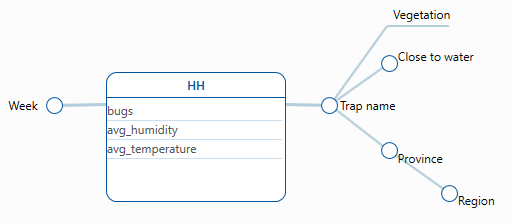

The procedure to create the cube is the following.

1. On the hh-traps.csv file, everything is fine, take all fields
2. On the hh-captures.csv:
  - Convert the date from the "yyyy-mm-dd" format to the week number; use PySpark's ```weekofyear()``` function inside the ```select()``` method
3. On the hh-weather.csv:
  1. Convert the character for decimal values from "," to "."
    1. Create a new column replacing the character
      - ```regexp_replace('column_name', ',', '\\.')```
    2. Create a new column casting to float
      - ```df['column_name'].cast("float")```
  2. Some temperature and humidity values are missing; replace null values with the average value of the month for the same province
    1. Create a new DataFrame:
      - without the null values - use ```df.na.drop()```
      - with the month instead of the day - use ```month(to_date(df.my_column,"dd/MM/yyyy"))``` 
    2. Aggregate by month and province to calculate average temperature and humidity
    3. Join with the original DataFrame
      - To join on multiple conditions (i.e., month and province), use the syntax ```df1.join(df2, cond)``` where ```cond``` is an array of join columns, defined as ```cond = ["columnA", "columnB"]```
    4. Use the ```select``` method to keep the ```coalesce(daily_temperature, monthly_temperature)``` and the ```toDF``` method to rename all columns
  3. Convert temperature values from Fahrenheit to Celsius; X°C = (Y°F - 32) * 5/9
  4. Aggregate the file to produce the average temperature and humidity per week and province
    1. Create a new column with the week number
    2. Aggregate on the week and province to calculate the average temperature and humidity
4. Join the weather file with the traps one (join on the province)
5. Join the result with the measurements file (join on the trapId and week)
6. Save the result on a file

In [ ]:
!wget https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/hh-traps.csv
!wget https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/hh-measurements.csv
!wget https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/notebooks/datasets/hh-weather.csv

In [ ]:
from pyspark.sql.functions import *
import datetime

## Spark

1. On the hh-traps.csv file, everything is fine, take all fields

In [ ]:
dfTraps = spark.read.option("delimiter", ";").option("header", "true").csv("hh-traps.csv")
dfTraps.show()

2. On the hh-captures.csv:
  - Convert the date from the "yyyy-mm-dd" format to the week number; use PySpark's ```weekofyear()``` function inside the ```select()``` method

In [ ]:
dfMeasurements = spark.read.option("delimiter", ";").option("header", "true").csv("hh-measurements.csv")
dfMeasurements.show()

In [ ]:
dfMeasurements1 = dfMeasurements\
  .withColumn("week",weekofyear(dfMeasurements.date))\
  .select("trapId","bugs","week")
dfMeasurements1.show()

3. On the hh-weather.csv:
  1. Convert the character for decimal values from "," to "."
    1. Create a new column replacing the character
      - ```regexp_replace('column_name', ',', '\\.')```
    2. Create a new column casting to float
      - ```df['column_name'].cast("float")```

In [ ]:
dfWeather = spark.read.option("delimiter", ";").option("header", "true").csv("hh-weather.csv")
dfWeather.show()

In [ ]:
dfWeather = dfWeather.withColumn('temperature', regexp_replace('temperature', ',', '\\.'))
dfWeather = dfWeather.withColumn('temperature', dfWeather['temperature'].cast("float"))
dfWeather = dfWeather.withColumn('humidity', regexp_replace('humidity', ',', '\\.'))
dfWeather = dfWeather.withColumn('humidity', dfWeather['humidity'].cast("float"))
dfWeather.show()

3. On the hh-weather.csv (continued):
  2. Some temperature and humidity values are missing; replace null values with the average value of the month for the same province
    1. Create a new DataFrame:
      - without the null values - use ```df.na.drop()```
      - with the month instead of the day - use ```month(to_date(df.my_column,"dd/MM/yyyy"))``` 
    2. Aggregate by month and province to calculate average temperature and humidity
    3. Join with the original DataFrame
      - To join on multiple conditions (i.e., month and province), use the syntax ```df1.join(df2, cond)``` where ```cond``` is an array of join columns, defined as ```cond = ["columnA", "columnB"]```
    4. Use the ```select``` method to keep the ```coalesce(daily_temperature, monthly_temperature)``` and the ```toDF``` method to rename all columns

In [ ]:
dfWeather1 = dfWeather\
  .na.drop()\
  .withColumn("month",month(to_date(dfWeather.day,"dd/MM/yyyy")))\
  .groupBy("province", "month").agg({'temperature': 'avg', 'humidity': 'avg'})
dfWeather1.show()

In [ ]:
dfWeather = dfWeather.withColumn("month", month(to_date(dfWeather.day,"dd/MM/yyyy")))

dfWeather2 = dfWeather.join(dfWeather1, ["province","month"])
dfWeather2.show()

In [ ]:
dfWeather3 = dfWeather2\
  .select("province","day",coalesce("temperature","avg(temperature)").alias("temperature"),coalesce("humidity","avg(humidity)"))\
  .toDF("province","day","temperature","humidity")
dfWeather3.show()

3. On the hh-weather.csv (continued):
  3. Convert temperature values from Fahrenheit to Celsius; X°C = (Y°F - 32) * 5/9
  4. Aggregate the file to produce the average temperature and humidity per week and province
    1. Create a new column with the week number
    2. Aggregate on the week and province to calculate the average temperature and humidity

In [ ]:
dfWeather4 = dfWeather3.withColumn("temperature",(dfWeather3.temperature-32)*5/9)
dfWeather4.show()

In [ ]:
dfWeather5 = dfWeather4\
  .withColumn("week", weekofyear(to_date(dfWeather4.day,"dd/MM/yyyy")))\
  .groupBy("province", "week").agg({'temperature': 'avg', 'humidity': 'avg'})
dfWeather5.show()

4. Join the weather file with the traps one (join on the province)
5. Join the result with the measurements file (join on the trapId and week)
6. Save the result on a file

In [ ]:
dfJ1 = dfWeather5.join(dfTraps,"province")
dfJ1.show()

In [ ]:
dfJ2 = dfJ1.join(dfMeasurements1,["trapId","week"])
dfJ2.show()

In [ ]:
dfJ2.write.mode('overwrite').option('header','true').csv("hh-cube")

## Tableau

Download the file from the left panel of this notebook (in case of issues, download it from [here](https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/tableau/hh-cube.csv)) and load it in Tableau.

- Create the hierarchies
- Create bins of size 20 for the vegetation field and of size 5 for the temperature
- Visualize the weekly trend of average bug captures for each province
- Find whether there is a correlatio between the average captures and the temperatures / provinces / closeness to water / vegetation. Use:
  - Simple bar charts (use bins for vegetation and temperature)
  - A scatter plot, by putting the trap's name in the "Details" mark (use continuous values for vegetation and temperature)

The final Tableau file will be available [here](https://raw.githubusercontent.com/w4bo/2022-bbs-dm/main/tableau/hh-cube.twb).